# Analysis Template for Stefan
This should briefly demonstrate the functions of two python classes that I built to interpret model data.

Import python packages, functions, and classes. My username may need to be switched out here.

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims
    )

from classes import SatComp_Metric, CT_SLF_Metric

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Check running location and adjust working directory appropriately.
The else case probably doesn't apply to you, but was nice when I was working by mounting FRAM remotely.
If running on NIRD, I don't think you need to make any changes. Not sure...

In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
satcomp_dir = 'satcomp/'
paramtest_dir = 'mnth15runs/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(satcomp_dir) and os.path.exists(paramtest_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


## Directories where model data are stored:
- /mnth15runs: This is a lot of my initial testing runs.
- /satcomp: These are runs that (mostly) ran nudged from 20200301 through 202000501 with COSP enabled

The naming convention is not great (or necessarily consistent). The format should be:
"yyyymmdd"\_"hhmmss"\_"filename"\_"casename"\_wbf\_"wbfmultipliervalue"\_inp\_"inpmultipliervalue"
Some keywords and what they mean:
- NorESM2: SLF variables added to CAM output, but no changes to the actual microphysics
- cam61_arctic2: NorESM2 with microphysics modifications to mixed-phase ice number concentration above 66N.
- CAM6: Most of the time this means the same as NorESM2, I think. It might mean CESM2.1.0 once or twice, but you could check by comparing what variables are available. Probably doesn't matter.


In [3]:
os.listdir(satcomp_dir)

['20200502_214847_singleparam_cam61_arctic2satcomp_wbf_0.2_inp_0.2',
 '20200327_132118_singleparam_noresm2satcomp_wbf_1_inp_1',
 '20200414_205148_singleparam_cam61satcomp_wbf_0.2_inp_0.3',
 '20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1',
 'unused',
 '20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1',
 '20200414_205148_singleparam_cam61satcomp_wbf_1_inp_0.05',
 'CESM2_slfvars']

## CT_SLF_Metric
This class was built to easily see how well the runs fit the SLF observations from Olimpia. It also does some nice plotting of variable profiles vertically and ratios. I didn't plan it, so it isn't very flexible in terms of looking at the Southern Ocean/Antarctica. It also isn't flexible in terms of loading files I think.

In [4]:
slfmetric = CT_SLF_Metric(satcomp_dir) # the argument here is the directory where your runs should be stored
# mainmetric.add_case('20200327_132118_singleparam_noresm2satcomp_wbf_1_inp_1') # origin point
slfmetric.add_case('20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1')
slfmetric.add_case('20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1')
slfmetric.add_case('20200414_205148_singleparam_cam61satcomp_wbf_0.2_inp_0.3') # origin point
slfmetric.add_case('20200414_205148_singleparam_cam61satcomp_wbf_1_inp_0.05')
slfmetric.add_case('20200502_214847_singleparam_cam61_arctic2satcomp_wbf_0.2_inp_0.2')
slfmetric.add_case('CESM2_slfvars')

Trying to load concatenated file for 20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200414_205148_singleparam_cam61satcomp_wbf_0.2_inp_0.3


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200414_205148_singleparam_cam61satcomp_wbf_1_inp_0.05


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200502_214847_singleparam_cam61_arctic2satcomp_wbf_0.2_inp_0.2


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for CESM2_slfvars


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


I mostly use this at this point to look at SLF fits in the Arctic compared to our CALIOP data from Olimpia:

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


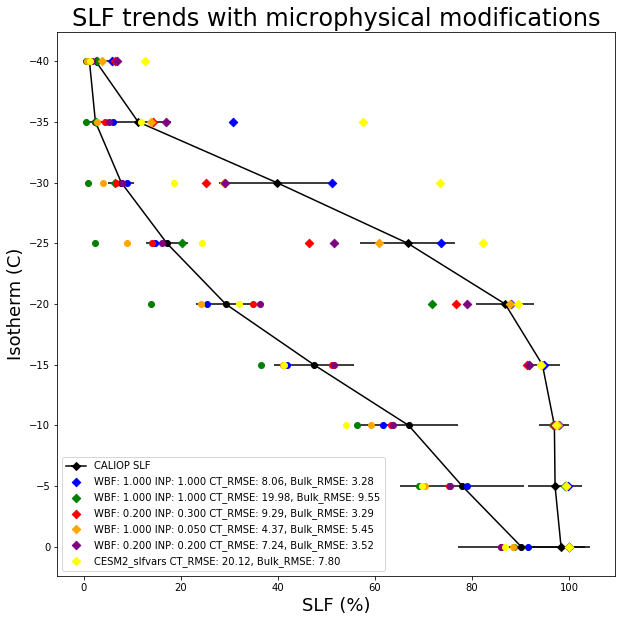

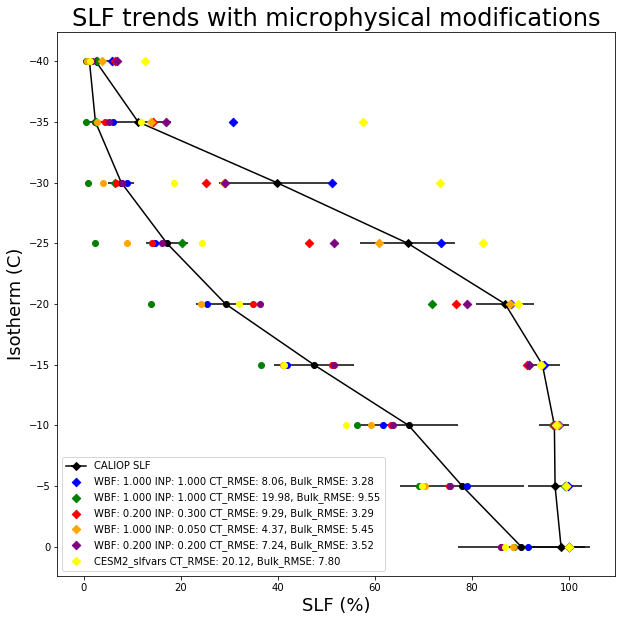

In [5]:
slfmetric.plot_isos_all()

You can plot variables with vertical profiles here. Specify the latitude bounds to get profiles outside of the Arctic.

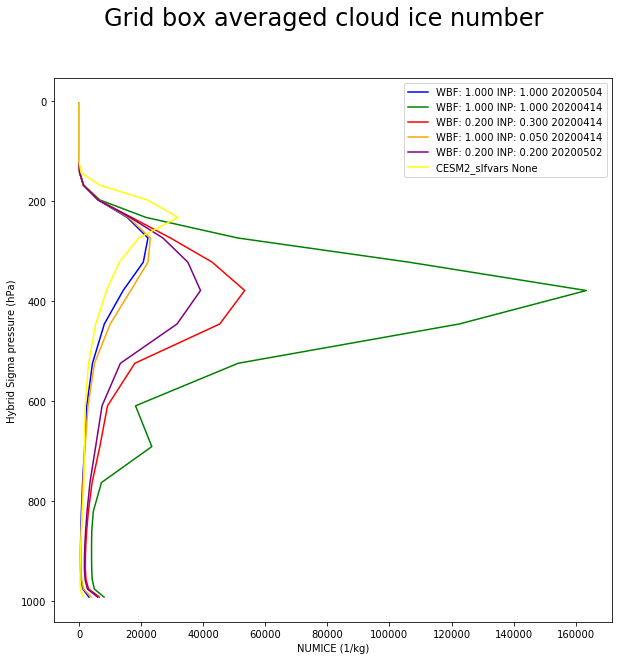

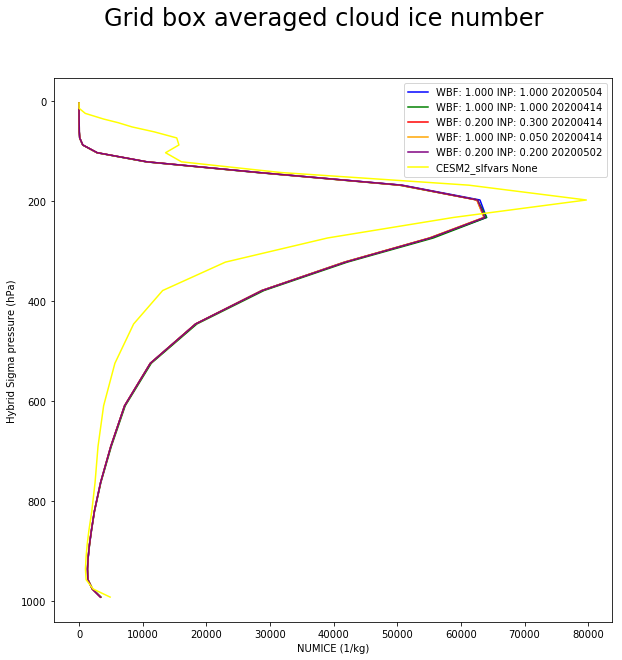

In [6]:
numice = slfmetric.plot_single_var('NUMICE')
numice = slfmetric.plot_single_var('NUMICE', lat_range=[-90,-60])

This plots a variable vs. vertical level when normalized to another variable. This was just necessary for a few CAM variables. Again, these will be Arctic by default unless you add the lat_range argument.

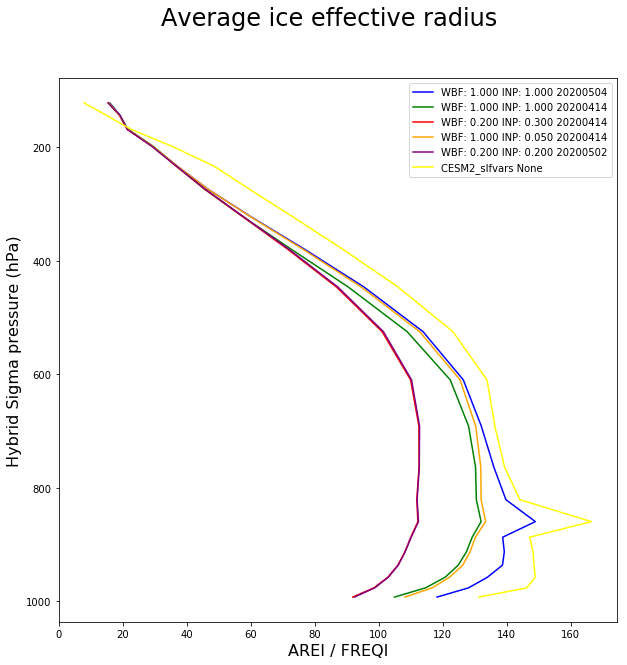

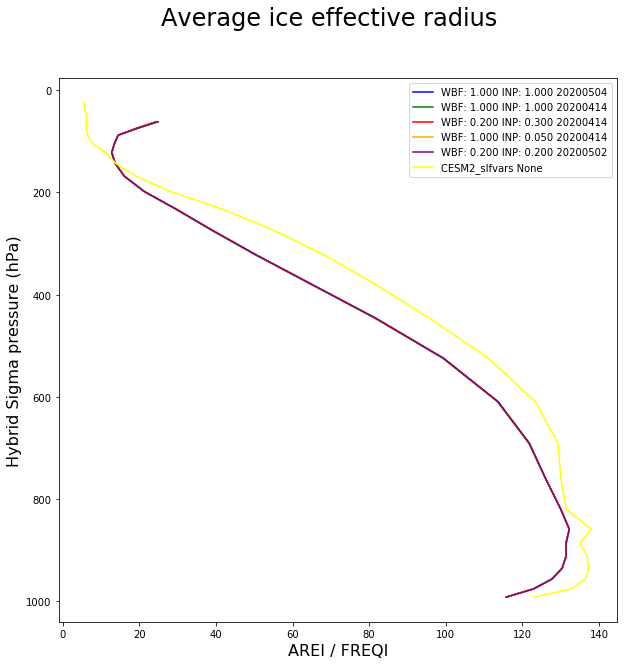

In [7]:
ice_rad = slfmetric.plot_var_ratio("AREI","FREQI")
ice_rad = slfmetric.plot_var_ratio("AREI","FREQI", lat_range=[-90,-60])
# ice_num = slfmetric.plot_var_ratio("AWNI","FREQI")

## SatComp_Metric
I wrote this specifically to generate plots similar to those in "Evaluating and improving cloud phase in the CommunityAtmosphere Model version 5 using spacebornelidar observations". It does comparisons with satellite products in the 2009-06 to 2013-05 period. I think that it was designed a little more intelligently and should be more flexible. There are definitely still bugs related to the legends and colorbars though.

It should also be faster because the files it is using are smaller and I think the code is more efficient. This also means that I have only loaded a subset of the total variables.

In [25]:
scm = SatComp_Metric(satcomp_dir)

Loading GOCCP data.
GOCCP data loaded.


In [26]:
scm.add_case('20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1')
scm.add_case('20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1')
scm.add_case('20200414_205148_singleparam_cam61satcomp_wbf_0.2_inp_0.3') # origin point
scm.add_case('20200414_205148_singleparam_cam61satcomp_wbf_1_inp_0.05')
scm.add_case('20200502_214847_singleparam_cam61_arctic2satcomp_wbf_0.2_inp_0.2')
scm.add_case('CESM2_slfvars')

Trying to load concatenated file for 20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1
20200504_145018_fitting_runs_cam6satcomp_wbf_1_inp_1 load successfully.
Trying to load concatenated file for 20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1
20200414_205148_singleparam_cam61satcomp_wbf_1_inp_1 load successfully.
Trying to load concatenated file for 20200414_205148_singleparam_cam61satcomp_wbf_0.2_inp_0.3
20200414_205148_singleparam_cam61satcomp_wbf_0.2_inp_0.3 load successfully.
Trying to load concatenated file for 20200414_205148_singleparam_cam61satcomp_wbf_1_inp_0.05
20200414_205148_singleparam_cam61satcomp_wbf_1_inp_0.05 load successfully.
Trying to load concatenated file for 20200502_214847_singleparam_cam61_arctic2satcomp_wbf_0.2_inp_0.2
20200502_214847_singleparam_cam61_arctic2satcomp_wbf_0.2_inp_0.2 load successfully.
Trying to load concatenated file for CESM2_slfvars
CESM2_slfvars load successfully.


If you want to select a single case for closer inspection:

In [14]:
_case = scm.get_case("CESM2_slfvars")
_da = _case.case_da # to get the actual xarray dataset object

The satellite data directly:

In [20]:
data = scm.goccp_data

In [22]:
data

<xarray.Dataset>
Dimensions:          (lat: 96, lon: 144, time: 48)
Coordinates:
  * lat              (lat) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon              (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * time             (time) datetime64[ns] 2009-06-15T14:04:06.093750016 ... 2013-05-12T22:48:16.875000
Data variables:
    CLDLOW_CAL_LIQ   (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    CLDMED_CAL_LIQ   (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    CLDHGH_CAL_LIQ   (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    CLDTOT_CAL_LIQ   (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    CLDLOW_CAL_ICE   (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    CLDMED_CAL_ICE   (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    CLDHGH_CAL_ICE   (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    CLDTOT_CAL_ICE   (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    CLDLOW_CAL_UN    (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    CLDMED_CAL_UN    (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    CLDHGH_CAL_UN    (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    CLDTOT_CAL_UN    (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    cllcalipso_RPIC  (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    clmcalipso_RPIC  (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    clhcalipso_RPIC  (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    cltcalipso_RPIC  (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    CLDLOW_CAL       (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    CLDMED_CAL       (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    CLDHGH_CAL       (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    CLDTOT_CAL       (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    clccalipso       (time, lat, lon) float32 dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
    cell_weight      (lat, lon) float64 1.013e-18 1.013e-18 ... 1.013e-18

## Plotting 2D

### Options are:
- Projection (uses cartopy projections)
- Season (pick a season)
- Seasonal (boolean, plot each season mean separately)
- Bias (show difference from satellite data (Model - Observation))
- Layers (plot either all the different cloud phase components for a given height layer, or all the different height components for a given phase)


### Basic Example:

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


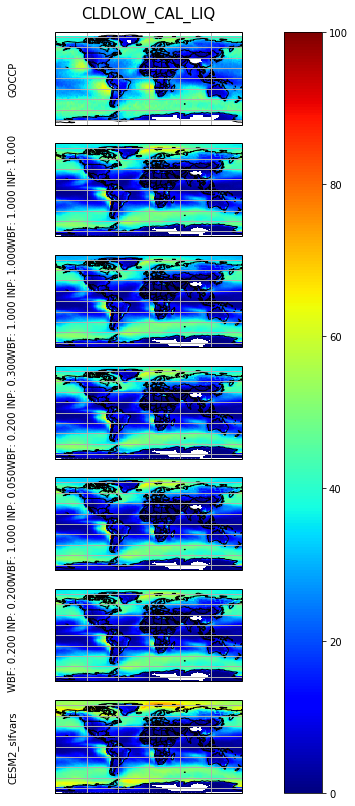

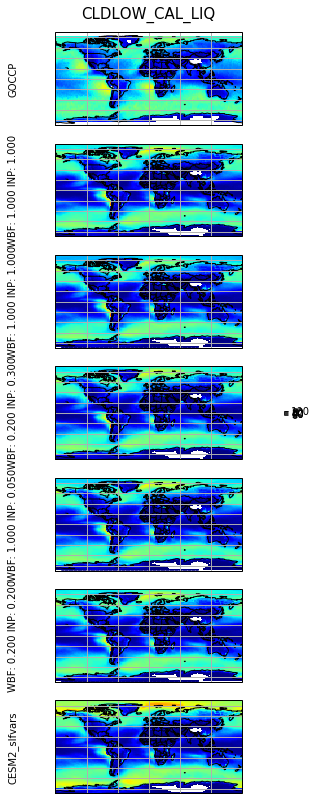

In [31]:
scm.plot2D('CLDLOW_CAL_LIQ')

### Advanced example:
At what layer is ice underestimated by CESM2 in the Arctic?

In [32]:
scm.plot2D("CLD_CAL_ICE", projection="Arctic", layers=True)

Layers prefix CLD_CAL_ICE not found. Select from: 

                ['CLDLOW_CAL', 'CLDMED_CAL', 'CLDHGH_CAL', 'CLDTOT_CAL', 'CAL_UN', 'CAL_LIQ', 'CAL_ICE'] 


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mea

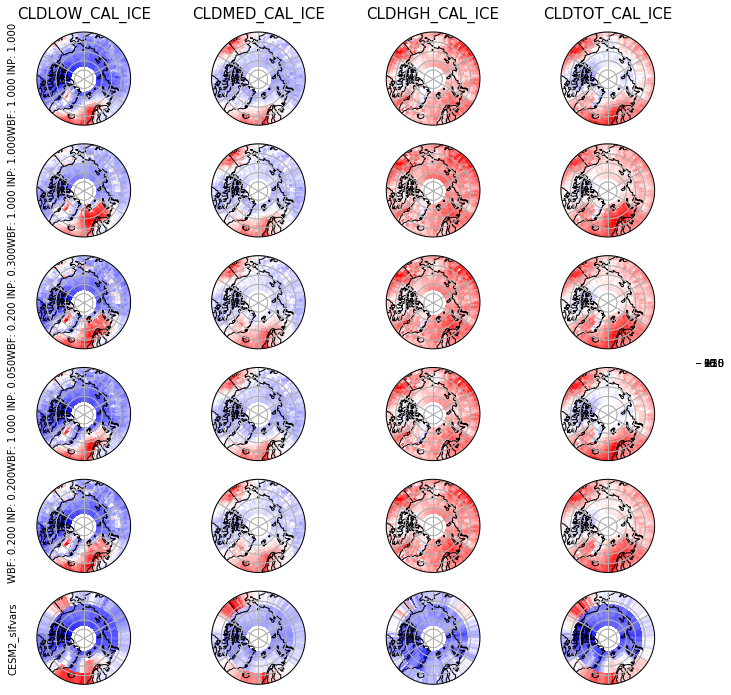

In [37]:
ice_layers = scm.plot2D("CAL_ICE", projection="Arctic", layers=True, bias=True)

Cool, it seems that CESM underestimates everywhere, while NorESM2 underestimates low ice clouds while overestimating high ice clouds.

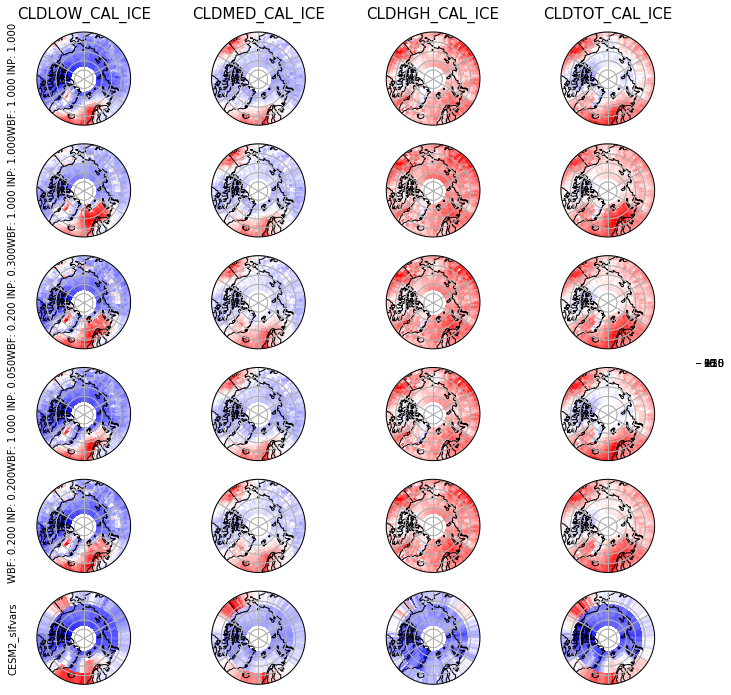

In [38]:
ice_layers

## Plotting 1D
Basically the same as 2D.

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


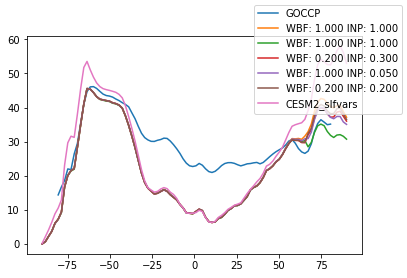

In [46]:
low_liq = scm.plot1D("CLDLOW_CAL_LIQ")

This would support your hypothesis that the cloud phase biases in the tropics and mid-latitudes are the result of low, convective clouds. I wonder if we can see it seasonally.

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


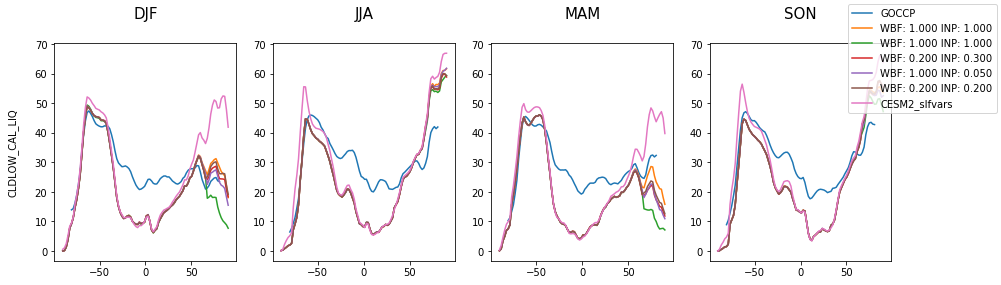

In [47]:
low_liq = scm.plot1D("CLDLOW_CAL_LIQ", seasonal=True)

Honestly, I don't take much away from this. Maybe you see something that I don't.

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


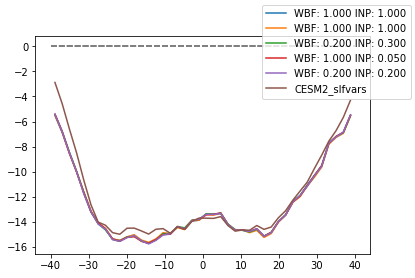

In [50]:
low_liq_bias = scm.plot1D("CLDLOW_CAL_LIQ", seasonal=False, bias=True, lat_range=[-40,40])

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


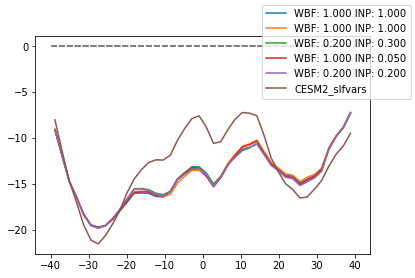

In [49]:
midbias = scm.plot1D("CLDTOT_CAL", seasonal=False, bias=True, lat_range=[-40,40])

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.p

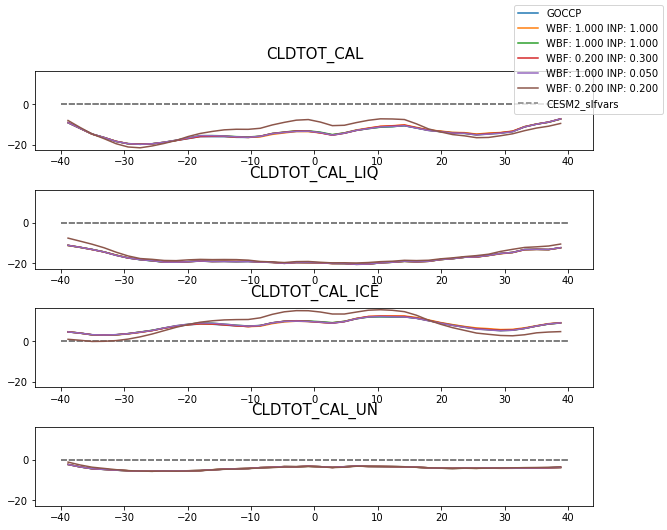

In [54]:
midbias_layered = scm.plot1D("CLDTOT_CAL", seasonal=False, bias=True, lat_range=[-40,40], layers=True)

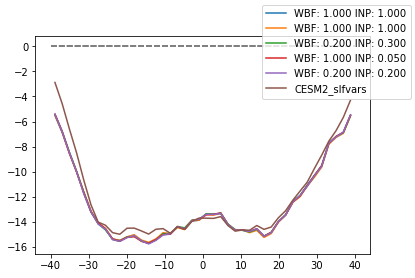

In [53]:
low_liq_bias

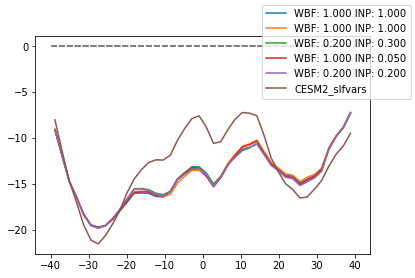

In [52]:
midbias